In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = pd.read_csv('dataset_info_parts.csv')
PATH_data = 'dataset/'
IMG_RESIZE_PATH_data = PATH_data+'images_resize/'
IMG_SIZE = (360,468)
BATCH_SIZE = 16
df['file_path'] = IMG_RESIZE_PATH_data + df['file']+'.jpg'
animals = ['sheep', 'dog', 'cow', 'cat', 'horse'] #{'horse': 0, 'cow': 1}

In [3]:
datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=10)#rescale=1./255)
train_ds = datagen.flow_from_dataframe(df[df['split']=='train'], x_col='file_path', y_col='cat', class_mode='categorical',
                                       target_size=(IMG_SIZE[0],IMG_SIZE[1]),batch_size=BATCH_SIZE, classes=animals)
val_ds = datagen.flow_from_dataframe(df[df['split']=='val'], x_col='file_path', y_col='cat', class_mode='categorical',
                                     target_size=(IMG_SIZE[0],IMG_SIZE[1]),batch_size=BATCH_SIZE, classes=animals)

Found 375 validated image filenames belonging to 5 classes.
Found 162 validated image filenames belonging to 5 classes.


In [4]:
IMG_SHAPE = IMG_SIZE + (3,)
inputs = tf.keras.Input(shape=IMG_SHAPE)
input_pre = tf.keras.applications.vgg16.preprocess_input(inputs)
base_model = tf.keras.applications.VGG16(input_tensor=input_pre, include_top=False, weights='imagenet')
base_model.trainable=False

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(animals), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 360, 468, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 360, 468, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 360, 468, 3)      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 360, 468, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 360, 468, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 180, 234, 64)      0         
                                                             

In [6]:
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=10000,decay_rate=0.9)
EPOCHS = 15
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
history = model.fit(train_ds,epochs=EPOCHS,validation_data=val_ds)
df_history =pd.DataFrame(history.history)

Epoch 1/15
24/24 [==============================] - 92s 3s/step - loss: 2.4028 - accuracy: 0.3013 - val_loss: 1.6179 - val_accuracy: 0.3642
Epoch 2/15
24/24 [==============================] - 63s 3s/step - loss: 1.2409 - accuracy: 0.5333 - val_loss: 1.1809 - val_accuracy: 0.5062
Epoch 3/15
24/24 [==============================] - 64s 3s/step - loss: 0.8369 - accuracy: 0.7067 - val_loss: 0.9334 - val_accuracy: 0.6420
Epoch 4/15
24/24 [==============================] - 60s 3s/step - loss: 0.6429 - accuracy: 0.7733 - val_loss: 0.8518 - val_accuracy: 0.6667
Epoch 5/15
24/24 [==============================] - 64s 3s/step - loss: 0.4904 - accuracy: 0.8453 - val_loss: 0.7614 - val_accuracy: 0.6975
Epoch 6/15
24/24 [==============================] - 61s 3s/step - loss: 0.4154 - accuracy: 0.8773 - val_loss: 0.7135 - val_accuracy: 0.7222
Epoch 7/15
24/24 [==============================] - 63s 3s/step - loss: 0.3376 - accuracy: 0.9200 - val_loss: 0.6732 - val_accuracy: 0.7346
Epoch 8/15
24/24 [==

base_model.trainable=True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
history = model.fit(train_ds,epochs=10,validation_data=val_ds)
df_history_ft =pd.DataFrame(history.history)
df_history_ft.index = df_history_ft.index+EPOCHS
df_history = pd.concat([df_history, df_history_ft])

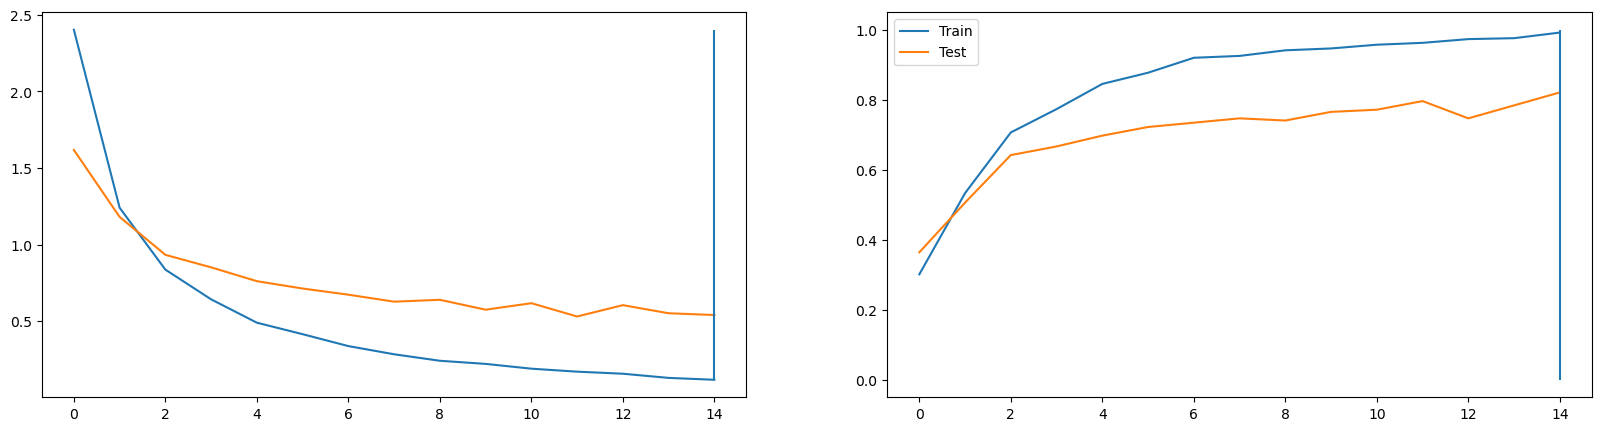

In [7]:
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(20,5))

axs[0].plot(df_history.index.values, df_history['loss'], label='Train')
axs[0].plot(df_history.index.values, df_history['val_loss'], label='Test')

axs[1].plot(df_history.index.values, df_history['accuracy'], label='Train')
axs[1].plot(df_history.index.values, df_history['val_accuracy'], label='Test')

axs[0].vlines(EPOCHS-1, min(df_history['loss']), max(df_history['loss']))
axs[1].vlines(EPOCHS-1, 0, 1)

plt.legend()

plt.show()

In [8]:
model.save('vgg16_model.h5')
df_history.to_csv('vgg16_train.csv')